<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PCA-of-correlation-matrix-(risks-x-canonical-variates)" data-toc-modified-id="PCA-of-correlation-matrix-(risks-x-canonical-variates)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PCA of correlation matrix (risks x canonical variates)</a></span><ul class="toc-item"><li><span><a href="#Boostrap-of-split-half-analysis" data-toc-modified-id="Boostrap-of-split-half-analysis-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Boostrap of split-half analysis</a></span><ul class="toc-item"><li><span><a href="#Matching-the-components" data-toc-modified-id="Matching-the-components-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Matching the components</a></span></li></ul></li><li><span><a href="#Original-split-half-analysis" data-toc-modified-id="Original-split-half-analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Original split-half analysis</a></span><ul class="toc-item"><li><span><a href="#Random-subset-1" data-toc-modified-id="Random-subset-1-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Random subset 1</a></span></li><li><span><a href="#Random-subset-2" data-toc-modified-id="Random-subset-2-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Random subset 2</a></span></li></ul></li><li><span><a href="#Bootstrapped-analysis-of-sex-specific-PCA" data-toc-modified-id="Bootstrapped-analysis-of-sex-specific-PCA-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Bootstrapped analysis of sex-specific PCA</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Matching-the-components" data-toc-modified-id="Matching-the-components-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Matching the components</a></span></li></ul></li><li><span><a href="#PCA-on-males-only" data-toc-modified-id="PCA-on-males-only-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>PCA on males only</a></span></li><li><span><a href="#PCA-on-females-only" data-toc-modified-id="PCA-on-females-only-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>PCA on females only</a></span></li></ul></li><li><span><a href="#All-participant-PCA" data-toc-modified-id="All-participant-PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>All participant PCA</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from matplotlib.pyplot import figure
from scipy import stats
from tqdm import tqdm
import os

In [3]:
data = pd.read_csv('HCDMNCOV_AD_2022.csv')

In [4]:
data.head()

,Unnamed: 0,eid,eid.1,father,mother,sibling,mf,mfs,Fluid intelligence score (R),Loneliness,...,e1/e3,e2/e2,e2/e3,e3/e3,e3/e4,e4/e4,e2_ranked,e4_ranked,APOE_ranked,IGF1
0,1000124.0,1000124.0,1000124.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.058670
1,1000181.0,1000181.0,1000181.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.681605
2,1000231.0,1000231.0,1000231.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.121311
3,1000247.0,1000247.0,1000247.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,-1.871221
4,1000250.0,1000250.0,1000250.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.004801


In [5]:
data.shape

(37291, 140)

**SUBGROUPING**

In [6]:
#sex
id_m = np.where((data['Sex']==1))
id_f = np.where((data['Sex']==0))
#age
id_young = np.where(data['Age']<=55.0)
id_old = np.where(data['Age']>55.0)
#sex x age 
id_young_m = np.where((data['Age']<=55.0)&(data['Sex']==1))
id_young_f = np.where((data['Age']<=55.0)&(data['Sex']==0))
id_old_m = np.where((data['Age']>55.0)&(data['Sex']==1))
id_old_f = np.where((data['Age']>55.0)&(data['Sex']==0))
#education
id_low_ed = np.where(data['Education score']<=6.69)
id_high_ed = np.where(data['Education score']>6.69)
#all 
id_all = np.where(data['eid.1']!= None)

**GET FEATURES**

In [7]:
def features (id):
    features = data.iloc[id]
    AD = features['mf']
    features_apoe = features[['e3/e3', 'e1/e3','e2/e2','e2/e3','e3/e4','e4/e4']]
    cca_modes = features[['1',
         '2',
         '3',
         '4',
         '5',
         '6',
         '7',
         '8',
         '9',
         '10',
         '11',
         '12',
         '13',
         '14',
         '15',
         '16',
         '17',
         '18',
         '19',
         '20',
         '21',
         '22',
         '23',
         '24',
         '25',
         '26',
         '27',
         '28',
         '29',
         '30',
         '31',
         '32',
         '33',
         '34',
         '35',
         '36',
         '37',
         '38',
         '39',
         '40',
         '41',
         '42',
         '43',
         '44',
         '45',
         '46',
         '47',
         '48',
         '49',
         '50']]
    risks = features[['Fluid intelligence score (R)',
              'Loneliness',
              'Lack of social support',
              'Age',
              'Sex',
              'Education score',
              'Age completed high school education',
              'Alcohol intake frequency',
              'Alcohol consumption on a typical drinking day',
              'Current tobacco smoking frequency',
              'Past tobacco smoking frequency',
              'Attend sports club or gym',
              'Attend pub or social club',
              'Attend religious group',
              'Attend adult education class',
              'Walking for pleasure',
              'Moderate exercises',
              'Strenuous sports',
              'Sleep duration',
              'Getting up in the morning',
              'Being a morning person',
              'Sleeplessness or insomnia',
              'Heart attack',
              'Angina',
              'Stroke',
              'Hypertension',
              'Diabetes diagnosed by a doctor',
              'Hearing difficulty with background noise',
              'Hearing aid user',
              'Glaucoma',
              'Cataract',
              'Macular degeneration',
              'Miserableness',
              'Fed-up feelings',
              'Mood swings',
              'Worrier / anxious feelings',
              'Nervous feelings',
              'Sensitivity / hurt feelings',
              "Tense / 'highly strung'",
              "Suffer from 'nerves'",
              'Worry too long after embarrassment',
              'Irritability',
              'Neuroticism score',
              'Happiness',
              'Feelings of nervousness or anxiety',
              'Frequency of friend / family visits',
              'Friendships satisfaction',
              'Family relationship satisfaction',
              'Number of full siblings',
              'Living in urban areas',
              'Average household income',
              'Paid employment',
              'Retirement',
              'Looking after home or family',
              'Unable to work due to sickness or disability',
              'Unemployment',
              'Doing unpaid or voluntary work',
              'Full or part-time student',
              'Number of vehicles in household',
              'Time spent watching TV',
              'Time spent using computer',
              'Number in household',
              'Physical environment score']]
    
    risks = risks.rename(columns={'Worrier / anxious feelings': 'Worrier_anxious',
                           'Fluid intelligence score (R)': 'Fluid intelligence score',
                           'Sensitivity / hurt feelings': 'Sensitivity_Hurt feelings',
                            "Tense / 'highly strung'":'Tense_Highly strung',
                           'Frequency of friend / family visits': 'Frequency of friend or family visits'})
    
    return AD, features_apoe, cca_modes, risks

In [8]:
#generating features for all participants
AD, features_apoe, all_modes, risks = features(id_all)

In [9]:
#z-scoring the risk factors
scaler = StandardScaler()
risks_z_scored = scaler.fit_transform(risks)

# PCA of correlation matrix (risks x canonical variates)

In [10]:
scaler = StandardScaler()
all_modes_zscored = scaler.fit_transform(all_modes)
all_modes_zscored2 = pd.DataFrame(all_modes_zscored, columns=range(1,51))

In [11]:
all_modes = all_modes_zscored2

In [12]:
#correlation between CCA modes and risk factors
def get_coefs(all_modes,risks, sex=False):
    
    scaler = StandardScaler()
    all_modes_zscored = scaler.fit_transform(all_modes)
    all_modes = pd.DataFrame(all_modes_zscored, columns=range(1,51))
    
    scaler = StandardScaler()
    risks_z_scored = scaler.fit_transform(risks)
    
    
    all_coefs = pd.DataFrame()
    for col in all_modes.columns:
        coef = []
        for i in range(0,len(risks_z_scored.T)):
            corr_matrix = np.corrcoef(all_modes[col],risks_z_scored.T[i])
            #print(corr_matrix)
            coef.append(corr_matrix[1][0])
        if sex == True:
            coef = np.array(coef).reshape(1,62)
        else:
            coef = np.array(coef).reshape(1,63)
        #index = np.array(index).flatten()
        #print(coef)
        #print(coef.shape)
        coef = pd.DataFrame(coef, columns = risks.columns)
        all_coefs = all_coefs.append(coef)
    all_coefs = all_coefs.reset_index(drop=True)
    all_coefs.index += 1
    return all_coefs

## Boostrap of split-half analysis

In [ ]:
all_coefs = get_coefs(features(id_all)[2],features(id_all)[3])

scaler = StandardScaler()
all_coefs_zscored = scaler.fit_transform(all_coefs)

In [ ]:
for i in tqdm(range(0,1000)):
    
    #resample with replacment 37291 participants to create a bootstrap distribution
    rand_dist = resample(data, replace=True, random_state = i, n_samples = 37291)
    rand_dist = rand_dist.reset_index()
    
    #generating two random subset of equal size 
    rand1 = rand_dist.sample(frac=0.5,random_state=i)
    rand2 = rand_dist[~rand_dist.index.isin(rand1.index)]
    
    #get Pearson's correlations coefficients for both random subsets
    rand1_coefs = get_coefs(features(rand1.index)[2],features(rand1.index)[3])
    rand2_coefs = get_coefs(features(rand2.index)[2],features(rand2.index)[3])
    
    #z-scoring subset 1 
    scaler = StandardScaler()
    rand1_coefs = scaler.fit_transform(rand1_coefs)
    #PCA for subset 1 
    pca_1 = PCA(n_components=3)
    risks_transformed_1 = pca_1.fit_transform(rand1_coefs.T)
    
    #saving results
    if i ==0:
        rand1_cpm = np.array(pca_1.components_.T)
        rand1_risks = np.array(risks_transformed_1)
        rand1_exp_var = np.array(pca_1.explained_variance_ratio_)
    else:
        rand1_cpm = np.append(rand1_cpm, pca_1.components_.T, axis=1)
        rand1_risks = np.append(rand1_risks, risks_transformed_1, axis=1)
        rand1_exp_var = np.append(rand1_exp_var, pca_1.explained_variance_ratio_)
    
#     #test
#     print(rand1_cpm.shape)
#     print(rand1_risks.shape) 

    #z-scoring subset 2
    scaler = StandardScaler()
    rand2_coefs = scaler.fit_transform(rand2_coefs)
    #PCA for subset 2
    pca_2 = PCA(n_components=3)
    risks_transformed_2 = pca_2.fit_transform(rand2_coefs.T)

    #saving results
    if i ==0:
        rand2_cpm = np.array(pca_2.components_.T)
        rand2_risks = np.array(risks_transformed_2)
        rand2_exp_var = np.array(pca_2.explained_variance_ratio_)
    else:
        rand2_cpm = np.append(rand2_cpm, pca_2.components_.T, axis=1)
        rand2_risks = np.append(rand2_risks, risks_transformed_2, axis=1)
        rand2_exp_var = np.append(rand2_exp_var, pca_2.explained_variance_ratio_)
    
#     #test
#     print(rand2_cpm.shape)
#     print(rand2_risks.shape)  

In [ ]:
rand1.shape

In [ ]:
rand2.shape

In [ ]:
np.savetxt("PCA/rand1_cpm.csv", rand1_cpm, delimiter=",")
np.savetxt("PCA/rand2_cpm.csv", rand2_cpm, delimiter=",")

np.savetxt("PCA/rand1_risks.csv", rand1_risks, delimiter=",")
np.savetxt("PCA/rand2_risks.csv", rand2_risks, delimiter=",")

np.savetxt("PCA/rand1_exp_var.csv", rand1_exp_var, delimiter=",")
np.savetxt("PCA/rand2_exp_var.csv", rand2_exp_var, delimiter=",")

### Matching the components

In [13]:
rand1_cpm = np.loadtxt('PCA/rand1_cpm.csv', delimiter=",")
rand2_cpm = np.loadtxt('PCA/rand2_cpm.csv', delimiter=",")

In [14]:
rand1_risk = np.loadtxt('PCA/rand1_risks.csv', delimiter=",")
rand2_risk = np.loadtxt('PCA/rand2_risks.csv', delimiter=",")

In [15]:
rand1_exp_var = np.loadtxt('PCA/rand1_exp_var.csv', delimiter=",")
rand2_exp_var = np.loadtxt('PCA/rand1_exp_var.csv', delimiter=",")

In [16]:
comp1 = np.mean(rand1_risk[:,::3], axis=1)
comp2 = np.mean(rand1_risk[:,1::3], axis=1)
comp3 = np.mean(rand1_risk[:,2::3], axis=1)

In [17]:
risks_transformed = np.array([comp1,comp2,comp3])

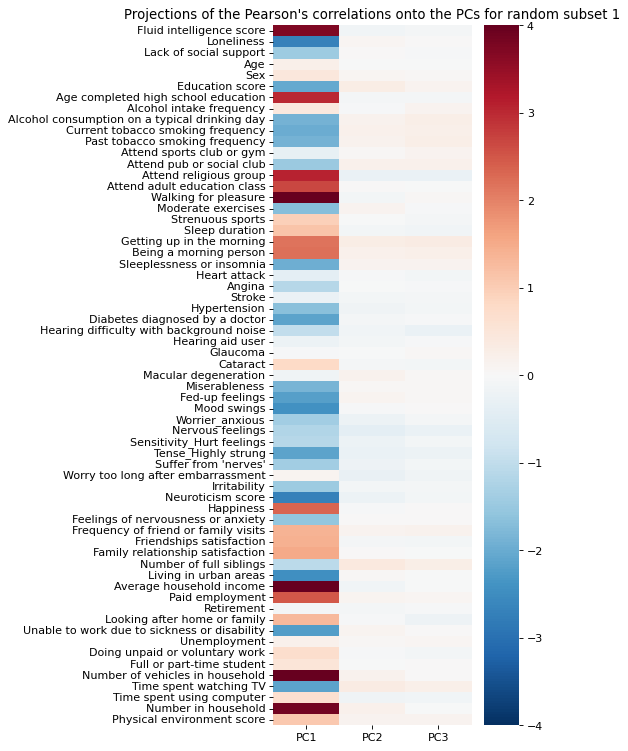

In [18]:
comp1 = np.mean(rand1_risk[:,::3], axis=1)
comp2 = np.mean(rand1_risk[:,1::3], axis=1)
comp3 = np.mean(rand1_risk[:,2::3], axis=1)

risks_transformed1 = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed1.T, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns,vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs for random subset 1')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand1_pca.png', dpi=200, bbox_inches='tight')
plt.show()

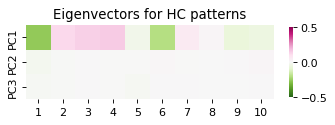

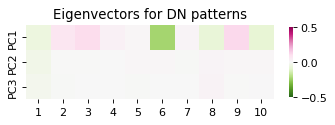

In [20]:
comp1 = np.mean(rand1_cpm[:,::3], axis=1)
comp2 = np.mean(rand1_cpm[:,1::3], axis=1)
comp3 = np.mean(rand1_cpm[:,2::3], axis=1)

comps = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps[:,0:10], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_HC.png', dpi=200, bbox_inches='tight')
plt.show()

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps[:,25:35], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_DN.png', dpi=200, bbox_inches='tight')
plt.show()

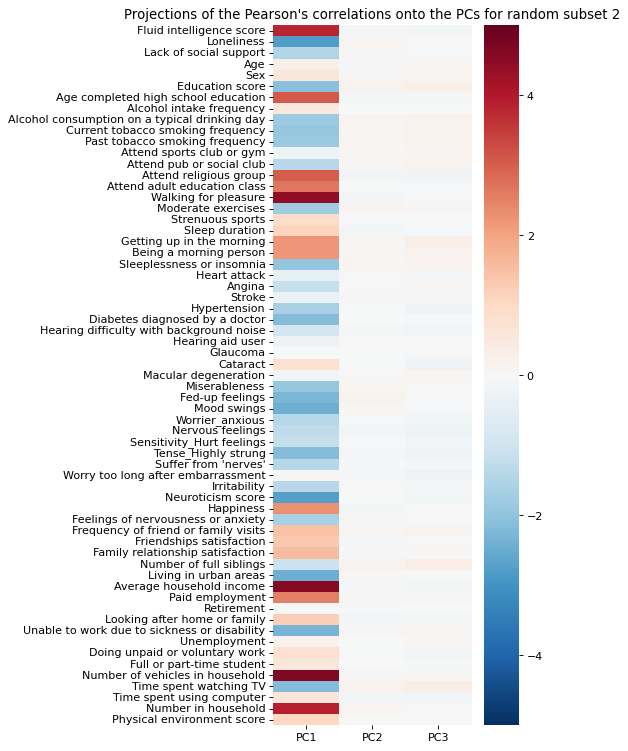

In [21]:
comp1 = np.mean(rand2_risk[:,::3], axis=1)
comp2 = np.mean(rand2_risk[:,1::3], axis=1)
comp3 = np.mean(rand2_risk[:,2::3], axis=1)

risks_transformed2 = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed2.T, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns,vmax=5, vmin=-5)
plt.title('Projections of the Pearson\'s correlations onto the PCs for random subset 2')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand2_pca.png', dpi=200, bbox_inches='tight')
plt.show()

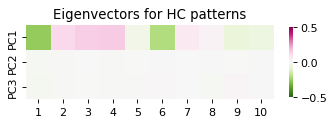

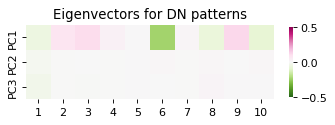

In [23]:
comp1 = np.mean(rand2_cpm[:,::3], axis=1)
comp2 = np.mean(rand2_cpm[:,1::3], axis=1)
comp3 = np.mean(rand2_cpm[:,2::3], axis=1)

comps = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps[:,0:10], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_HC.png', dpi=200, bbox_inches='tight')
plt.show()

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps[:,25:35], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_DN.png', dpi=200, bbox_inches='tight')
plt.show()

In [24]:
#original analysis
all_coefs = get_coefs(features(id_all)[2],features(id_all)[3])

scaler = StandardScaler()
all_coefs_zscored = scaler.fit_transform(all_coefs)

pca = PCA(n_components=3)
risks_transformed = pca.fit_transform(all_coefs_zscored.T)

In [25]:
from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment


n_BS_perm = 1000
n_keep = 3
#creating list to store the pearson's correlation coefficients for each component
rhos_1 = []
rhos_2 = []
rhos_3 = []

rand1_comp1 = []
rand1_comp2 = []
rand1_comp3 = []

rand1_risk1 = []
rand1_risk2 = []
rand1_risk3 = []

rand1_ev1 = []
rand1_ev2 = []
rand1_ev3 = []

rand2_comp1 = []
rand2_comp2 = []
rand2_comp3 = []

rand2_risk1 = []
rand2_risk2 = []
rand2_risk3 = []

rand2_ev1 = []
rand2_ev2 = []
rand2_ev3 = []

for i_bs in tqdm(range(n_BS_perm)):
        
    corr_mat = np.corrcoef(pca.components_.T[:,:].T,rand1_cpm[:,0+i_bs:3+i_bs].T)
    #original PCA is rows 
    corr_mat = np.abs(corr_mat[:3,3:])
    #descending order
    row_ind_1, col_ind_1 = linear_sum_assignment(-corr_mat)
    #print(row_ind_1)

    corr_mat = np.corrcoef(pca.components_.T[:,:].T,rand2_cpm[:,0+i_bs:3+i_bs].T)
    #original PCA is rows 
    corr_mat = np.abs(corr_mat[:3,3:])
    #descending order
    row_ind_2, col_ind_2 = linear_sum_assignment(-corr_mat)
    #print(row_ind_2)      

    rhos_1.append(abs(stats.pearsonr(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[0]],
                                rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[0]])[0]))

    rand1_comp1.append(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[0]])
    rand2_comp1.append(rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[0]])
    
    rand1_risk1.append(rand1_risk[:,0+i_bs:3+i_bs][:,col_ind_1[0]])
    rand2_risk1.append(rand2_risk[:,0+i_bs:3+i_bs][:,col_ind_2[0]])
    
    rhos_2.append(abs(stats.pearsonr(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[1]],
                        rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[1]])[0]))
    
    rand1_comp2.append(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[1]])
    rand2_comp2.append(rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[1]])
    
    rand1_risk2.append(rand1_risk[:,0+i_bs:3+i_bs][:,col_ind_1[1]])
    rand2_risk2.append(rand2_risk[:,0+i_bs:3+i_bs][:,col_ind_2[1]])
    
#     rand1_ev2.append(rand1_exp_var[:,0+i_bs:3+i_bs][:,col_ind_1[1]])
#     rand2_ev2.append(rand2_exp_var[:,0+i_bs:3+i_bs][:,col_ind_2[1]])

    rhos_3.append(abs(stats.pearsonr(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[2]],
                        rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[2]])[0]))
    
    rand1_comp3.append(rand1_cpm[:,0+i_bs:3+i_bs][:,col_ind_1[2]])
    rand2_comp3.append(rand2_cpm[:,0+i_bs:3+i_bs][:,col_ind_2[2]])  
    
    rand1_risk3.append(rand1_risk[:,0+i_bs:3+i_bs][:,col_ind_1[2]])
    rand2_risk3.append(rand2_risk[:,0+i_bs:3+i_bs][:,col_ind_2[2]])
    
#     rand1_ev3.append(rand1_exp_var[:,0+i_bs:3+i_bs][:,col_ind_1[2]])
#     rand2_ev3.append(rand2_exp_var[:,0+i_bs:3+i_bs][:,col_ind_2[2]])

# plt.figure(figsize=(10,6))
# plt.hist(rhos_1, bins=25, alpha=0.5, label = 'Component 1')
# plt.hist(rhos_2, bins=25, alpha=0.5, label = 'Component 2')
# plt.hist(rhos_3, bins=25, alpha=0.5, label = 'Component 3')

# plt.xlabel("Pearson's rhos", size=15)
# plt.ylabel("Number of boostrap iterations", size=15)
# plt.title(f"Pearson's correlations between the PCA loadings of random subsets 1 and 2 across 1,000 bootstrap iterations", size = 12)
# plt.legend(loc='upper left')
# plt.savefig(f'PCA/optimal_matched_rhos_hist_split_half.png', dpi=200, bbox_inches='tight')
# plt.show()
        
        

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1902.26it/s]


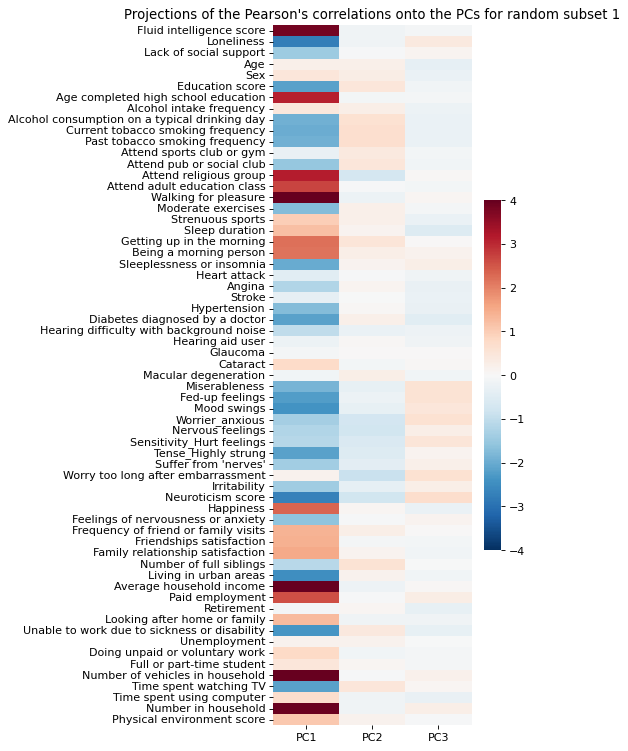

In [26]:
comp1 = np.mean(np.array(rand1_risk1),axis=0)
comp2 = np.mean(np.array(rand1_risk2),axis=0)
comp3 = np.mean(np.array(rand1_risk3),axis=0)

risks_transformed1 = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed1.T, cmap=plt.cm.RdBu_r, center=0, cbar_kws={"shrink": 0.5}, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns,vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs for random subset 1')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand1_pca.png', dpi=200, bbox_inches='tight')
plt.show()

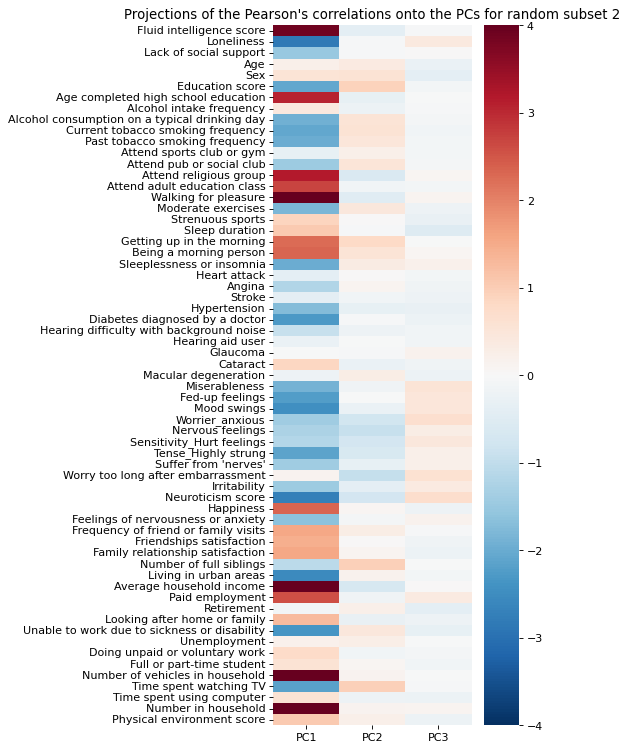

In [27]:
comp1 = np.mean(np.array(rand2_risk1),axis=0)
comp2 = np.mean(np.array(rand2_risk2),axis=0)
comp3 = np.mean(np.array(rand2_risk3),axis=0)

risks_transformed2 = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed2.T, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns,vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs for random subset 2')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand2_pca.png', dpi=200, bbox_inches='tight')
plt.show()

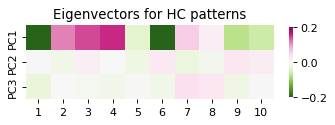

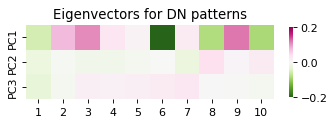

In [28]:
comp1 = np.mean(np.array(rand1_comp1),axis=0)
comp2 = np.mean(np.array(rand1_comp2),axis=0)
comp3 = np.mean(np.array(rand1_comp3),axis=0)


comps_rand1 = np.array([comp1,comp2,comp3])

#print(comps_rand1)

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps_rand1[:,0:10], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_HC.png', dpi=200, bbox_inches='tight')
plt.show()

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps_rand1[:,25:35], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_DN.png', dpi=200, bbox_inches='tight')
plt.show()

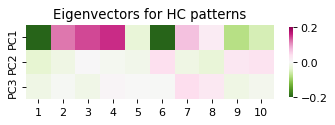

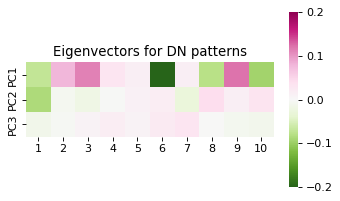

In [29]:
comp1 = np.mean(np.array(rand2_comp1),axis=0)
comp2 = np.mean(np.array(rand2_comp2),axis=0)
comp3 = np.mean(np.array(rand2_comp3),axis=0)


comps_rand2 = np.array([comp1,comp2,comp3])

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps_rand2[:,0:10], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_HC.png', dpi=200, bbox_inches='tight')
plt.show()

%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(comps_rand2[:,25:35], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.5}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_DN.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
rhos = pd.DataFrame(index=['component_1','component_2','component_3'],columns=['mean','5th_percentile', '25th_percentile', 'median','75th_percentile','95th_percentile'])

rhos['mean'] = [np.mean(rhos_1),np.mean(rhos_2),np.mean(rhos_3)]
rhos['5th_percentile'] = [np.percentile(rhos_1, 5),np.percentile(rhos_2, 5),np.percentile(rhos_3, 5)]
rhos['25th_percentile'] = [np.percentile(rhos_1, 25),np.percentile(rhos_2, 25),np.percentile(rhos_3, 25)]
rhos['median'] = [np.percentile(rhos_1, 50),np.percentile(rhos_2, 50),np.percentile(rhos_3, 50)]
rhos['75th_percentile'] = [np.percentile(rhos_1, 75),np.percentile(rhos_2, 75),np.percentile(rhos_3, 75)]
rhos['95th_percentile'] = [np.percentile(rhos_1, 95),np.percentile(rhos_2, 95),np.percentile(rhos_3, 95)]

In [ ]:
rhos.head()

In [ ]:
rhos.to_csv('split_half_bootstrap_distributions.csv')

## Original split-half analysis

In [ ]:
rand1 = data.sample(frac=0.5,random_state=42)
rand2 = data[~data.index.isin(rand1.index)]

In [ ]:
rand1_coefs = get_coefs(features(rand1.index)[2],features(rand1.index)[3])
rand2_coefs = get_coefs(features(rand2.index)[2],features(rand2.index)[3])

In [ ]:
#z-scoring
scaler = StandardScaler()
rand1_coefs = scaler.fit_transform(rand1_coefs)

scaler = StandardScaler()
rand2_coefs = scaler.fit_transform(rand2_coefs)

In [ ]:
rand1_coefs.shape

### Random subset 1

In [ ]:
pca = PCA(n_components=3)
risks_transformed = pca.fit_transform(rand1_coefs.T)
pca.explained_variance_ratio_

In [ ]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,0:10], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_HC.png', dpi=200, bbox_inches='tight')

In [ ]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,25:35], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand1_DN.png', dpi=200, bbox_inches='tight')

In [ ]:
%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns,vmax=5, vmin=-5)
plt.title('Projections of the Pearson\'s correlations onto the PCs for random subset 1')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand1_pca.png', dpi=200, bbox_inches='tight')
plt.show()

### Random subset 2

In [ ]:
pca = PCA(n_components=3)
risks_transformed = pca.fit_transform(rand2_coefs.T)
pca.explained_variance_ratio_

In [ ]:
%matplotlib inline
figure(figsize=(5, 10), dpi=80)
sns.heatmap(pca.components_[:,0:10], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_HC.png', dpi=200, bbox_inches='tight')

In [ ]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,25:35], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.5, vmax = 0.5)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_rand2_DN.png', dpi=200, bbox_inches='tight')

In [ ]:
%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.drop('Sex',axis=1).columns, cbar_kws={"shrink": 0.4}, vmax=5, vmin=-5)
plt.title('Projections of the Pearson\'s correlations onto the PCs for for random subset 2')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/rand2_pca.png', dpi=200, bbox_inches='tight')
plt.show()

## Bootstrapped analysis of sex-specific PCA 

In [ ]:
#generating features for males participants
AD_m, features_apoe_m, all_modes_m, risks_m = features(id_m)

In [ ]:
#generating features for females participants
AD_f, features_apoe_f, all_modes_f, risks_f = features(id_f)

In [60]:
for i in tqdm(range(0,1000)):
    
    AD_m, features_apoe_m, all_modes_m, risks_m = features(id_m)
    AD_f, features_apoe_f, all_modes_f, risks_f = features(id_f)
    
    all_modes_m, risks_m = resample(all_modes_m, risks_m.drop('Sex',axis=1), replace=True, random_state = i, n_samples = 17561)
    all_modes_f, risks_f = resample(all_modes_f, risks_f.drop('Sex',axis=1), replace=True, random_state = i, n_samples = 19730)
    
    all_coefs_m = get_coefs(all_modes_m,risks_m, sex=True)
    all_coefs_f = get_coefs(all_modes_f,risks_f, sex=True)
    
    #z-scoring males
    scaler = StandardScaler()
    z_all_coefs_m = scaler.fit_transform(all_coefs_m)
    
#     print(z_all_coefs_m.shape)
    
    #PCA for males
    pca_m = PCA(n_components=3)
    risks_transformed_m = pca_m.fit_transform(z_all_coefs_m.T)
    
    #saving results
    if i ==0:
        males_cpm = np.array(pca_m.components_.T)
        males_risks = np.array(risks_transformed_m)
        males_exp_var = np.array(pca_m.explained_variance_ratio_)
    else:
        males_cpm = np.append(males_cpm, pca_m.components_.T, axis=1)
        males_risks = np.append(males_risks, risks_transformed_m, axis=1)
        males_exp_var = np.append(males_exp_var, pca_m.explained_variance_ratio_)
    
#     #test
#     print(males_cpm.shape)
#     print(males_risks.shape) 

    #z-scoring females
    scaler = StandardScaler()
    z_all_coefs_f = scaler.fit_transform(all_coefs_f)
    
#     print(z_all_coefs_f.shape)
    
    #PCA for females
    pca_f = PCA(n_components=3)
    risks_transformed_f = pca_f.fit_transform(z_all_coefs_f.T)

    #saving results
    if i ==0:
        females_cpm = np.array(pca_f.components_.T)
        females_risks = np.array(risks_transformed_f)
        females_exp_var = np.array(pca_f.explained_variance_ratio_)
    else:
        females_cpm = np.append(females_cpm, pca_f.components_.T, axis=1)
        females_risks = np.append(females_risks, risks_transformed_f, axis=1)
        females_exp_var = np.append(females_exp_var, pca_f.explained_variance_ratio_)
    
#     #test
#     print(females_cpm.shape)
#     print(females_risks.shape)  

100%|███████████████████████████████████████| 1000/1000 [25:28<00:00,  1.53s/it]


In [ ]:
np.savetxt("PCA/females_cpm.csv", females_cpm, delimiter=",")
np.savetxt("PCA/males_cpm.csv", males_cpm, delimiter=",")

np.savetxt("PCA/females_risks.csv", females_risks, delimiter=",")
np.savetxt("PCA/males_risks.csv", males_risks, delimiter=",")

np.savetxt("PCA/females_exp_var.csv", females_exp_var, delimiter=",")
np.savetxt("PCA/males_exp_var.csv", males_exp_var, delimiter=",")

### Plotting

In [58]:
f_cpm = np.loadtxt('PCA/females_cpm.csv', delimiter=",")
m_cpm = np.loadtxt('PCA/males_cpm.csv', delimiter=",")

In [59]:
f_risk = np.loadtxt('PCA/females_risks.csv', delimiter=",")
m_risk = np.loadtxt('PCA/males_risks.csv', delimiter=",")

In [61]:
f_cpm = females_cpm
m_cpm = males_cpm

In [62]:
f_risk = females_risks
m_risk = males_risks

### Matching the components

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2549.34it/s]


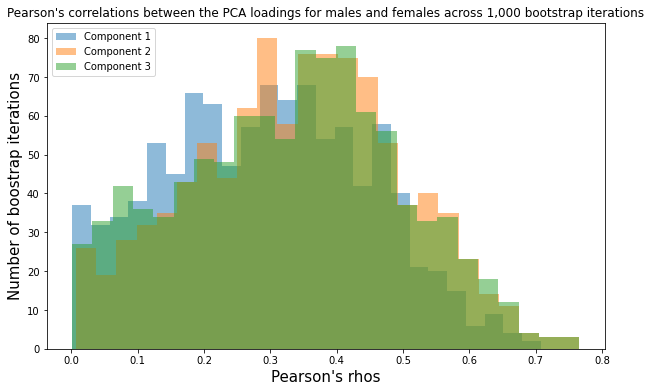

In [75]:
from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment


n_BS_perm = 1000
n_keep = 3
#creating list to store the pearson's correlation coefficients for each component
rhos_1 = []
rhos_2 = []
rhos_3 = []

f_comp1 = []
f_comp2 = []
f_comp3 = []

f_risk1 = []
f_risk2 = []
f_risk3 = []

f_ev1 = []
f_ev2 = []
f_ev3 = []

m_comp1 = []
m_comp2 = []
m_comp3 = []

m_risk1 = []
m_risk2 = []
m_risk3 = []

m_ev1 = []
m_ev2 = []
m_ev3 = []



for i_bs in tqdm(range(n_BS_perm)):
        
    corr_mat = np.corrcoef(m_cpm[:,0+i_bs:3+i_bs].T,f_cpm[:,0+i_bs:3+i_bs].T)
    #original PCA is rows 
    corr_mat = np.abs(corr_mat[:3,3:])
    
    #descending order
    m_ind, f_ind = linear_sum_assignment(-corr_mat)
    
    if np.array_equal(m_ind, np.array([2, 1, 0])):
        m_ind = np.array([0, 1, 2])
        
    if np.array_equal(f_ind, np.array([2, 1, 0])):
        f_ind = np.array([0, 1, 2])
    
#     print(f_ind)
#     print(m_ind)
    
    rhos_1.append(abs(stats.pearsonr(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[0]],
                        m_cpm[:,0+i_bs:3+i_bs][:,m_ind[0]])[0]))
    
    f_comp1.append(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[0]])
    m_comp1.append(m_cpm[:,0+i_bs:3+i_bs][:,m_ind[0]])
    
    f_risk1.append(f_risk[:,0+i_bs:3+i_bs][:,f_ind[0]])
    m_risk1.append(m_risk[:,0+i_bs:3+i_bs][:,m_ind[0]])
    
    rhos_2.append(abs(stats.pearsonr(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[1]],
                        m_cpm[:,0+i_bs:3+i_bs][:,m_ind[1]])[0]))
    
    f_comp2.append(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[1]])
    m_comp2.append(m_cpm[:,0+i_bs:3+i_bs][:,m_ind[1]])
    
    f_risk2.append(f_risk[:,0+i_bs:3+i_bs][:,f_ind[1]])
    m_risk2.append(m_risk[:,0+i_bs:3+i_bs][:,m_ind[1]])
        
    rhos_3.append(abs(stats.pearsonr(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[2]],
                        m_cpm[:,0+i_bs:3+i_bs][:,m_ind[2]])[0]))
    
    f_comp3.append(f_cpm[:,0+i_bs:3+i_bs][:,f_ind[2]])
    m_comp3.append(m_cpm[:,0+i_bs:3+i_bs][:,m_ind[2]])
    
    f_risk3.append(f_risk[:,0+i_bs:3+i_bs][:,f_ind[2]])
    m_risk3.append(m_risk[:,0+i_bs:3+i_bs][:,m_ind[2]])
    
plt.figure(figsize=(10,6))
plt.hist(rhos_1, bins=25, alpha=0.5, label = 'Component 1')
plt.hist(rhos_2, bins=25, alpha=0.5, label = 'Component 2')
plt.hist(rhos_3, bins=25, alpha=0.5, label = 'Component 3')

plt.xlabel("Pearson's rhos", size=15)
plt.ylabel("Number of boostrap iterations", size=15)
plt.title(f"Pearson's correlations between the PCA loadings for males and females across 1,000 bootstrap iterations", size = 12)
plt.legend(loc='upper left')
#plt.savefig(f'PCA/matched_hist_males_females.png', dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
rhos = pd.DataFrame(index=['component_1','component_2','component_3'],columns=['mean','5th_percentile', '25th_percentile', 'median','75th_percentile','95th_percentile'])

rhos['mean'] = [np.mean(rhos_1),np.mean(rhos_2),np.mean(rhos_3)]
rhos['5th_percentile'] = [np.percentile(rhos_1, 5),np.percentile(rhos_2, 5),np.percentile(rhos_3, 5)]
rhos['25th_percentile'] = [np.percentile(rhos_1, 25),np.percentile(rhos_2, 25),np.percentile(rhos_3, 25)]
rhos['median'] = [np.percentile(rhos_1, 50),np.percentile(rhos_2, 50),np.percentile(rhos_3, 50)]
rhos['75th_percentile'] = [np.percentile(rhos_1, 75),np.percentile(rhos_2, 75),np.percentile(rhos_3, 75)]
rhos['95th_percentile'] = [np.percentile(rhos_1, 95),np.percentile(rhos_2, 95),np.percentile(rhos_3, 95)]

In [ ]:
rhos.to_csv('males_females_bootstrap_distributions.csv')

## PCA on males only 

In [116]:
all_coefs_m = get_coefs(features(id_m)[2],features(id_m)[3].drop('Sex',axis=1), sex=True)

In [117]:
scaler = StandardScaler()
all_coefs_m = scaler.fit_transform(all_coefs_m)

In [118]:
pca_m = PCA(n_components=3)
risks_transformed = pca_m.fit_transform(all_coefs_m.T)
pca_m.explained_variance_ratio_

array([0.1214178 , 0.09864675, 0.08971204])

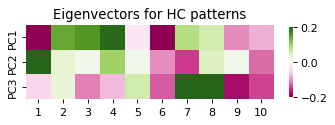

In [84]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,0:10], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_males_HC.png', dpi=200, bbox_inches='tight')

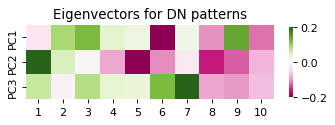

In [83]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,25:35], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_males_DN.png', dpi=200, bbox_inches='tight')

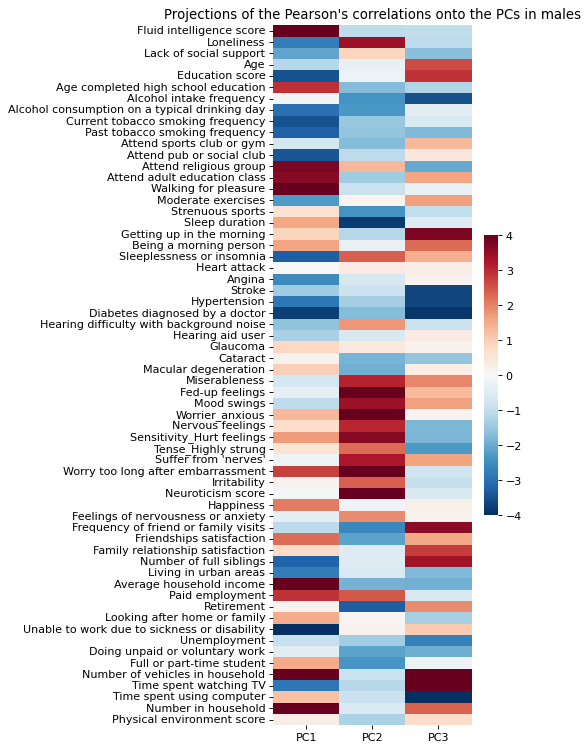

In [119]:
%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.drop('Sex',axis=1).columns, cbar_kws={"shrink": 0.4}, vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs in males')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/males_pca.png', dpi=200, bbox_inches='tight')

## PCA on females only

In [111]:
all_coefs_f = get_coefs(features(id_f)[2],features(id_f)[3].drop('Sex',axis=1), sex=True)

In [112]:
scaler = StandardScaler()
all_coefs_f = scaler.fit_transform(all_coefs_f)

In [113]:
pca_f = PCA(n_components=3)
risks_transformed = pca_f.fit_transform(all_coefs_f.T)
pca_f.explained_variance_ratio_

array([0.13164791, 0.09450397, 0.07349186])

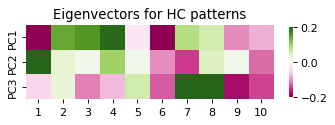

In [93]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,0:10], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_females_HC.png', dpi=200, bbox_inches='tight')

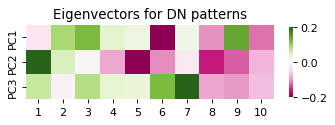

In [94]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,25:35], cmap='PiYG', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_females_DN.png', dpi=200, bbox_inches='tight')

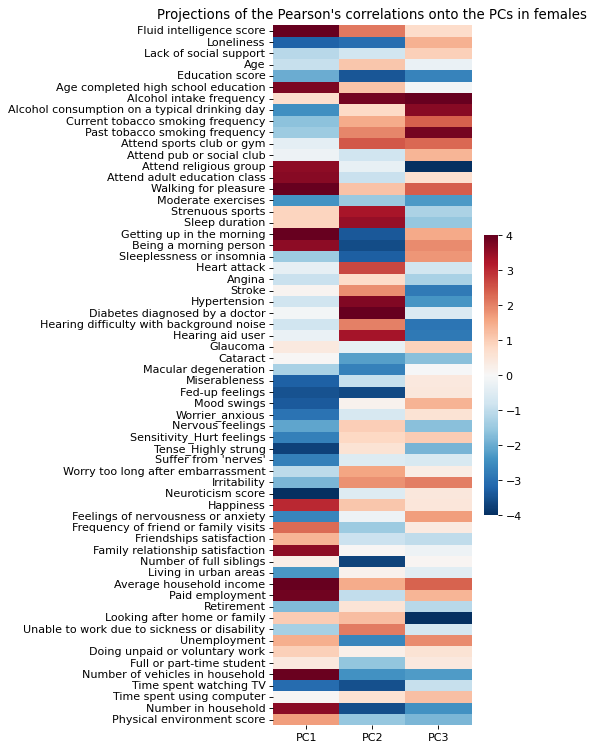

In [114]:
# XXX of each mode to each latent risk factor
%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.drop('Sex',axis=1).columns, cbar_kws={"shrink": 0.4}, vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs in females')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_females.png', dpi=200, bbox_inches='tight')

# All participant PCA

In [100]:
all_coefs = get_coefs(features(id_all)[2],features(id_all)[3])

scaler = StandardScaler()
all_coefs_zscored = scaler.fit_transform(all_coefs)

pca = PCA(n_components=3)
risks_transformed = pca.fit_transform(all_coefs_zscored.T)

In [101]:
pca.explained_variance_ratio_

array([0.13763775, 0.0955899 , 0.08214607])

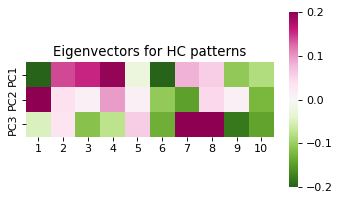

In [106]:
#correlation of each mode to each latent risk factor
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,0:10], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.5}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for HC patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_all_HC_V2.png', dpi=200, bbox_inches='tight')

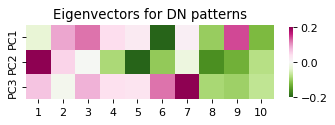

In [107]:
%matplotlib inline
figure(figsize=(5, 5), dpi=80)
sns.heatmap(pca.components_[:,25:35], cmap='PiYG_r', square = True, center=0, yticklabels=['PC1','PC2','PC3'], xticklabels=range(1,11), cbar_kws={"shrink": 0.2}, vmin = -0.2, vmax = 0.2)
plt.title('Eigenvectors for DN patterns')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_eigenvetcors_all_DN_V2.png', dpi=200, bbox_inches='tight')

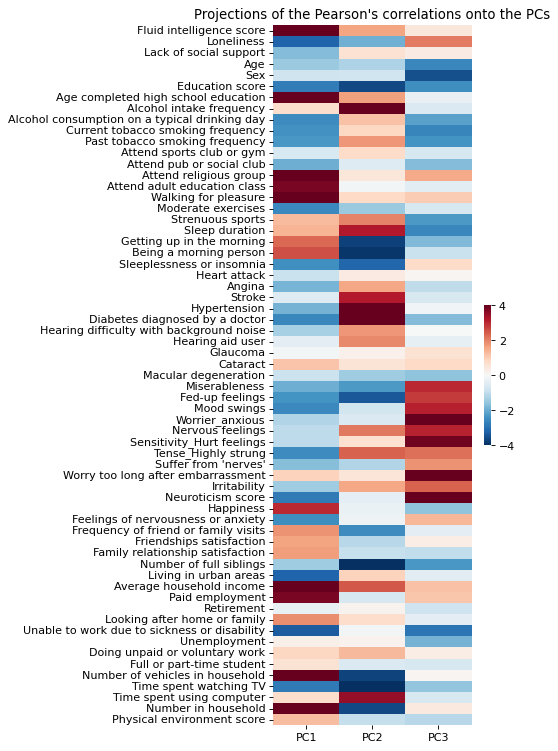

In [110]:
# XXX of each mode to each latent risk factor
%matplotlib inline
figure(figsize=(4, 10), dpi=80)
sns.heatmap(risks_transformed, cmap=plt.cm.RdBu_r, center=0, xticklabels=['PC1','PC2','PC3'], yticklabels=risks.columns, cbar_kws={"shrink": 0.2}, vmax=4, vmin=-4)
plt.title('Projections of the Pearson\'s correlations onto the PCs')
#plot1_path = 'CCA_plots/all/CCA_APOE_AD/DMN_APOE_interactions_AD.png'
#plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig('PCA/pca_projections_V2.png', dpi=200, bbox_inches='tight')